<h1> Exercises 1: Basic Radar Processing </h1>
In this notebook we have a few exercises and examples of code such that you can run it, play around with it to better understand how radar signal processing is performed in Python.

First we need to load any libraries that might be used.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.save_adc_data as sd
import processing.utility as utility

<h5> 1. Setting up Paths and Loading Data: </h5>
To load your data, please make sure the file paths are all correct. The variables/functions are setup expecting a specific way of your project directory organization, however it is up to you how you want to organize it. Step through these variables to make sure you are loading what is expected. 

In the end, it is up to you how you want to link the paths. We've set it up in a way that should work if you follow the path conventions however you are welcome to look through all the functions called in order to determine how you want to input path names. Since the size of the data depends on your specific chirp paramters (such as number of frames, number of transmitters used, number of receivers used, number of chirp loops used, number of ADC samples used), we will leave this code for you understand whether you need to make changes for your future project.

The function utility.read_radar_param() will take the Lua script you give it and extract all the chirp parameters that are declared at the top of the file.

In [2]:
# TODO: Put the *name* of your .bin file here (excluding the .bin)
filename = r"1"
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"
# TODO: Put the path (relative to home_dir) of the captured data folder
capture_data_dir = r"data"
# TODO: Put the path (relative to home_dir) and name of the JSON files (exlude the .setup.json and .mmwave.json)
json_filename = r"scripts/chirp1"
path_to_rawdata = os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))
config_lua_script = r'scripts/1843_config.lua' 

# this function reads the parameters from your lua config file (look at this function to see how it expects your config file to be formatted)
num_tx, num_rx, adc_samples, periodicity, num_frames, chirp_loops, _, _, _ = utility.read_radar_params(os.path.join(home_dir,config_lua_script))
######### only edit here if you want to change the chirp paramters!!!! #############
tx_en = '0x7' # HEX enable (1 for on, 0 for off)
rx_en = '0xF' # HEX enable (1 for on, 0 for off)

args = [num_tx, num_rx, adc_samples, chirp_loops, tx_en, rx_en]

Loading the data requires loading the *.bin file you measured using mmWave Studio and converting it to a *.mat file. You only have to do this conversion once if the data has not changed in that file. All this does is convert the raw data (which will be a binary file with the data separated by real and imaginary parts and interleaved based on the transmitter/reciever pairs) to a multidimensional array so that we can interpret it. This array will be complex valued of the size: (Number of Frames x Number of Transmitter Chirps x Number of Receivers x Number of ADC Samples). This is all done in the function sd.save_adc_data().

Then we load the *.mat file, using sio.loadmat() and extract the raw ADC data.

In [3]:
############################# Reformat the Data #############################
if not os.path.exists(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')):
    sd.save_adc_data(filename, home_dir, capture_data_dir, json_filename)

################################# load data #################################
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))
raw_data = np.array(bin_data['data_raw'])

print("You captured %d frames, for %d TX, %d Rx, and %d adc samples" % raw_data.shape)

You captured 20 frames, for 3 TX, 4 Rx, and 512 adc samples


<h5> 2. Range FFT: </h5> 

There is some simple signal processing we can do to have a coarse understanding of what we've received. Below, is code for processing and plotting the range FFT as you have seen in the lectures, AKA we take the FFT of the raw signal (along the dimension of the ADC samples), which gives you the frequency difference between the received signals. Based on this you should also be able to locate the strongest reflector and recover the distance of that reflector. 

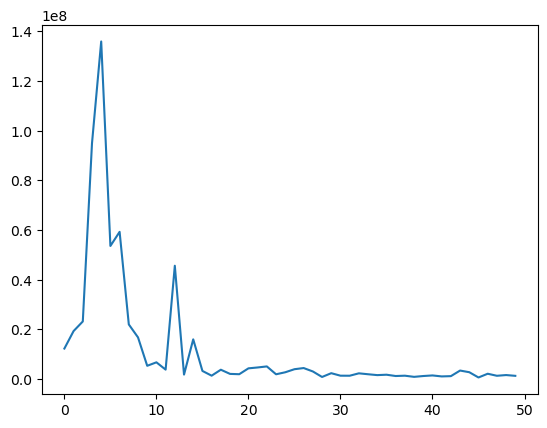

In [4]:
############################### process data! ################################
# Range FFT
rfft = scipy.fft.fft(raw_data, axis=3)
plt.plot(abs(np.squeeze(np.sum(rfft[:,:,:,0:50],axis=(0,2,1)))))

Now find the distance of the maximum reflector that is seen in front of the radar.

In [9]:
######## Find the distance of the maximum reflector in front of the radar. #############
# TODO: add your code here
def max_reflector(rfft):
    # put your implementation here
    return

In [10]:
max_reflector(rfft)

<h5> 3. Beamforming </h5>

To help understand some of the ways to more accurately visualize radar data, we have provided some raw ADC data, processing code and some examples of Python plotting code to play around with. First we will go through the process of beamforming which you have seen in the lectures, and show the bird eye view (BEV) heatmaps we can recover from this.
For beamforming, it requires knowing a few details about the antenna array that captured the data. We will describe it in more detail later in this notebook.
For the rest of this section, the horizontal dimension will be defined as *x*, vertical as *z*, and depth will be defined by *y*. 

First, we load the data provided.


In [5]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"data_001"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
X = raw_data[num_x_stp//2,num_z_stp//2,:,:,:]

In this exercise, we are only using 4 receivers and the first transmitter. For a better understanding of the layout of the physical antennas, you can check out the documentation on the AWR1843BOOST Evaluation Board. 
The four receivers have a spacing of $\lambda$/2 apart. 
We assume that the origin (aka 0,0,0) is the first antenna, and looking from the point of view of the radar, positive-x will be to the right, positive-y will be in front of the radar, and positive-z will be up. 
Because of the orientation the radar was placed and the layout of where the first antenna is, each of the subsequent antennas will actually be placed at -$\lambda$/2. 

Make sure you understand the orientation of the radar and antennas as you will see a much larger array in the next exercise. 

In [6]:
# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) * -lm / 2
rx_pos = rx_pos - rx_pos[0]
ant_pos = rx_pos

For the beamforming algorithm, we first perform the range FFT along the ADC samples.

In [7]:
# just look at one vertical dimension since we are not using elevation
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(-1,adc_samples))


Here we define the function for beamforming in one dimension. AKA we are using a one dimensional array and only beamforming along the azimuth (horizontal) direction. So the output we see will be a 2D heatmap where one dimension is the range or depth (which we got from the range FFT), and the other dimension is the azimuth angles (which we get from beamforming).

Recall that in beamforming, we are compensating for the additional distance traveled by a signal when it arrives at the antennas at an angle so that the singals will sum up constructively. Thus, we simply multiply each antenna's signal by that offset in the phase (this array is sometimes called the beam steering vector) and sum the signals. By iterating over a set of angles, we can calculate the power coming from each direction.

In [8]:
# TODO: calculate the beamforming vector used to steer the beams
def steering_vec(theta,locs):
    '''
    Calculates the steering vector based on the angle given (theta) and the antenna array locations. 
    
    Paramters: 
    - theta: angle of arrival that we are calculating the steering vector for (radians)
    - locs: antenna locations

    Returns:
    - bf_vector: steering vector
    '''

    cos_theta = np.cos(theta) # angle that the signal is coming from 
    bf_vector = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))

    return bf_vector

Because of array dimensions and having to stick to Python function formalities, we need to make sure the size of array holding the phase offsets is the correct size to do element-wise multiplication.

In [9]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_1d(beat_freq_data, theta_s, theta_e, theta_res, locs):
    """
    Performs 1D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s: first angle that you want to start computing 
    - theta_e: last angle that you want to compute 
    - theta_res: resolution of the angles you want to compute
    - locs: antenna locations

    Returns:
    - sph_pwr: beamformed result
    - theta: the array of the angles computed
    """
    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        Vec = steering_vec(theta[kt],locs)
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1)) # make sure the size of the steering vector is the same as the data
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f)" % (theta[kt]*180/np.pi), end='\r')
    return sph_pwr, theta

Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

In [10]:
# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 0, 180
theta_res = 1
print(beat_freq.shape)
bf_output, theta = beamform_1d(beat_freq, theta_s,theta_e,theta_res, ant_pos)

(4, 512)
Running this many iterations: 180 


We can plot the output here. Here, we will make sure we are labeling the x-axis with the angle in radians (0 is the origin, +$\pi$ is the right most view point and -$\pi$ is the left most view point). The y-axis is labeled in meters. You can see that the output is not very good, basically it is hard to tell exactly where the reflector is, and this is because the antenna array used in this case is extremely small, giving us very low resolution. 

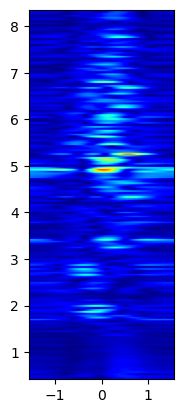

In [11]:
plot_lim_y = [10,200]
plot_lim_x = [0 - theta_s,179 - theta_s]
to_plot = bf_output
to_plot = to_plot[plot_lim_x[0]:plot_lim_x[1],plot_lim_y[0]:plot_lim_y[1]]
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
to_plot = to_plot[:,::-1]
plt.imshow(abs((to_plot).T), extent=[theta[plot_lim_x[0]]-np.pi/2, theta[plot_lim_x[1]]-np.pi/2,plot_lim_y[0] * 0.041763,plot_lim_y[1] * 0.041763],cmap = 'jet',  vmin=0, vmax=1.2) # this is giving the y axis in meters, and x axis in angles 

<h5> 4. Matched Filter:</h5> 
Here we will compute the matched filter output for the captured data. See the lectures for more details on the matched filter algortihm. 
The high level idea is that we calculate the round trip distance of each point in x,y,z and estimate the signal that we could receive from that point, we then correlate this estimated signal with the raw data and do this for every point in space. 
Eventually we should get a matrix holding the 2D space, with the output that corresponds to the most highly correlated scene. 


In [12]:
######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_1d: raw ADC data (size: num Tx * num Rx, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_y_cells: discrete locations in Y (range/depth) that you want to compute the power of
    - x_radar_tx: positions of the transmitters 
    - x_radar_rx: positions of the receivers 
    
    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)

    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                
                # calculate the distance from each antenna to the the point cell_x, cell_y in space
                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)

                # account for range bias (because of the hardware there is some delay in the circuit which causes a ~15cm offset in what we are expecting to get)
                cell_dist = cell_dist + 0.15 
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau

                # get the real and imaginary part of the signal
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)

                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f)" % (cell_x,cell_y), end='\r')
    return MF_output 

For the matched filter, we don't perform the range FFT and correlate with the raw signal directly. 
We run the matched filter algorithm on a set of pixels defined by num_x_cells and num_y_cells. 

Then, we need to define the locations of both the transmitter and the reciever (since the round trip distance needs to be from the transmitter to the receiver, which are not located at the same position). We calculated the receiver locations same as for the beamforming antenna locations. For the transmitter location, since we only have one, we just need to match the size of the receiver, since each of the four receivers are getting the reflected signal from the same transmitter. So we have an array with 4 of the same values which correspond to the location of the transmitter relative to the first receiver. In this case there is a 5mm offset from the last receiver, and then we also need to shift the location since there are 3 additional receivers between the first receiver and the first transmitter. 

In [13]:
X = np.squeeze(raw_data[num_x_stp//2,num_z_stp//2,:,:,:]) # for matched filter we use the raw data directly!
X = np.reshape(X,(-1,adc_samples))
num_x_cells = np.arange(-1,1,0.02)
num_y_cells = np.arange(4,6,0.2)

x_radar_tx = np.zeros(ant_pos.shape) - 0.005 - 3 * lm / 2
x_radar_rx = ant_pos

MF_output = matched_filter_1d(X, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx)

Now we will plot the heatmap computed below. Again, we have labeled the x-axis and the y-axis as the location in meters. 

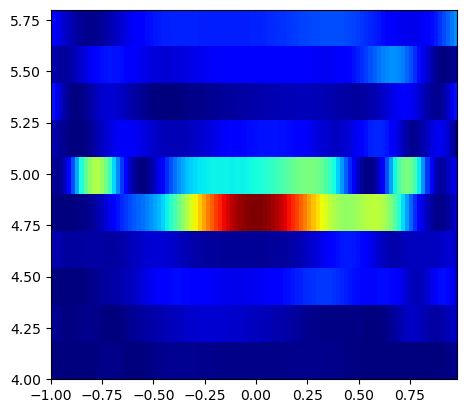

In [14]:
to_plot = (MF_output[::-1,::-1])**2
plt.imshow(abs(to_plot.T), extent=[num_x_cells[0], num_x_cells[-1], num_y_cells[0], num_y_cells[-1]],cmap = 'jet') # this is giving the y axis in meters, and x axis in angles 

In this notebook, you should've gone through exercises on loading data, basic processing and plotting. In the section of this notebook you will see a more complex example of both beamforming and matched filter. Another thing you can try on your own is estimating the angle of arrival. In other words, in which direction is the reflector relative to the antennas. 

<h1> Exercises 2: More complex radar data!</h1>
In this section, we have a more complex example of beamforming and matched filter. The majority of the complexity will be seen in the antenna position declaration, since the beamforming algorithm and the matched filter algorithm should remain the same. 

In [15]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import time

Nothing done.


<h5> 1. Beamforming </h5>

To help understand some of the ways to visualize radar data better, we have provided some processed data and some examples of Python plotting code to play around with. First we will go through the process of beamforming and show the bird eye view (BEV) heatmaps we can recover from this.
For beamforming, it requires knowing a few details about the antenna array that captured the data. We will describe it in more detail below.
For the rest of this section, the horizontal dimension will be defined as *x*, vertical as *z*, and depth will be defined by *y*. 

First, we load the data provided.


In [16]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"data_008"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape


Now we will describe the antenna array pattern. The data provided was taken by scanning a much smaller radar and set of antennas (same as exercise_1.ipynb) to emulate a larger antenna array. This is also known as SAR (Synthetic Aperture Radar), which you should have seen in the pre-recorded lectures.

The scanning radar has 1 transmitter and 4 receivers. The receivers are spaced $\lambda$/2 apart, and the transmitter is offset by 0.005 + $\lambda$/2. 
The receiver antenna pattern is defined in the variable *rx_pos*. The transmitter locations are only needed in the matched filter code, which you will see more details there.

Then, we scan the radar horizontally and vertically. In this portion, only the horizontal scan is used (we will aribitarily pick one vertical location and use that), and we leave the implementation of recreating the 2D image for the evaluation.

The radar is moved along the x-axis 80 times, each time moving by a distance $\lambda$, which you can see is defined by the variable *x_pos*. Finally, *ant_pos* defines the total receiver antenna scanning pattern. 

In [24]:
# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing

# this is the receiver positions
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) * -lm / 2

# this is the locations of the locations of the radar (we are moving it by lambda) 
x_pos = (np.reshape(np.arange(1,81,dtype=float),(-1,1))) * lm

# antenna positions for all receivers in the entire scan. /lm so that we don't have two factors of lm when we multiply them
ant_pos = np.reshape(np.array([rx_pos + x_pos[i] for i in range(len(x_pos))]),(-1,1))
ant_pos = ant_pos - ant_pos[0] # make sure first location is 0
x_pos = x_pos - x_pos[0] # make sure first location is 0

In [27]:
# TODO: calculate the beamforming vector used to steer the beams (HINT: this should be the same as exercise_1)
def steering_vec(theta,locs):
    '''
    Calculates the steering vector based on the angle given (theta) and the antenna array locations. 
    
    Paramters: 
    - theta: angle of arrival that we are calculating the steering vector for (radians)
    - locs: antenna locations

    Returns:
    - bf_vector: steering vector
    '''


    cos_theta = np.cos(theta) # angle that the signal is coming from 
    bf_vector = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))

    return bf_vector

In some cases, there is a lot of self-interference between the antennas when we scan, and it appears as a very very strong signal very close to the radar. Thus, we sometimes will pass the raw signal through a highpass filter to get rid of the strong signals at the lower frequencies. You can try with and without this highpass filter and see how it affects the images. 

In [28]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_1d(beat_freq_data, theta_s, theta_e,theta_res,locs):
    """
    Performs 1D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s: first angle that you want to start computing 
    - theta_e: last angle that you want to compute 
    - theta_res: resolution of the angles you want to compute
    - locs: antenna locations

    Returns:
    - sph_pwr: beamformed result
    - theta: the array of the angles computed
    """
    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        start_time = time.time()
        Vec = steering_vec(theta[kt],locs)
        # Vec = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1))
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f) took %.2f sec" % (theta[kt]*180/np.pi, start_time - time.time()), end='\r')
    return sph_pwr, theta

Take the first verical scan, and the range FFT of the raw ADC data.

In [29]:
# just look at one vertical dimension since we are not using elevation
X = raw_data[:,0,:,:,:]
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(-1,adc_samples))

Run the beamforming algorithm! Here we are doing theta from 70 degrees to 130 degrees.

In [30]:
# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 70, 130
theta_res = 1
bf_output, theta = beamform_1d(beat_freq, theta_s,theta_e,theta_res,ant_pos)

Running this many iterations: 61 


Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

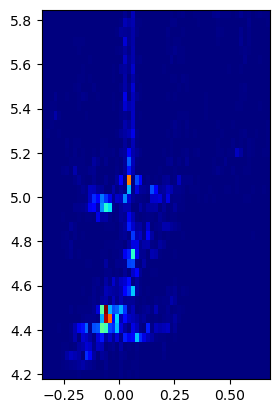

In [31]:
plot_lim_y = [100,140]
plot_lim_x = [70 - theta_s,129 - theta_s]
to_plot = bf_output
to_plot = to_plot[plot_lim_x[0]:plot_lim_x[1],plot_lim_y[0]:plot_lim_y[1]]
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1))) 
to_plot = to_plot[:,::-1]**2
plt.imshow(abs((to_plot).T), extent=[theta[plot_lim_x[0]]-np.pi/2, theta[plot_lim_x[1]]-np.pi/2,plot_lim_y[0] * 0.041763,plot_lim_y[1] * 0.041763],cmap = 'jet',  vmin=0, vmax=0.7) # this is giving the y axis in meters, and x axis in angles 

<h5> 2. Matched Filter:</h5> 
Here we will compute the matched filter output but for a more complex antenna pattern. If you take a look at this function and the one in exercise_1.ipynb it should be virtually the same. 

In [32]:
######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_1d: raw ADC data (size: num Tx * num Rx, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_y_cells: discrete locations in Y (range/depth) that you want to compute the power of
    - x_radar_tx: positions of the transmitters 
    - x_radar_rx: positions of the receivers 

    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)

    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                start_time = time.time()

                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)                
                cell_dist = cell_dist + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f) took %.2f sec" % (cell_x,cell_y, start_time - time.time()), end='\r')
    return MF_output 

Now we will reshape the raw data and create the cartesian coordinates that we will calculate outputs for. 
Again because this is a 1D matched fitler implementation, we will take a sample from the center of the 2D aperture. *num_x_cells* denotes the x coordinates that we will compute correlations for, and *num_y_cells* will denote the y coordinates that we compute correlations for. 

We also will define the antenna positions for the transmitter and the receivers. Again, to match the dimensions of the receivers when doing matrix addition, we create an array of the transmitter locations where every 4 spots will be the same location so as to match the number of receivers when calculating round trip distance. The transmitter location moves by $\lambda$/2 each time (which is just the *x_pos* array), and we repeat that 4 times for the 4 receivers. We then also have the shift the transmitter location by (0.005 + 3 $\lambda$/2). 

The receiver locations are just defined as *ant_pos*.

In [33]:
X = np.squeeze(raw_data[:,0,:,:,:]) # for matched filter we use the raw data directly!
X = np.reshape(X,(-1,adc_samples))

num_x_cells = np.arange(-1.5,1.5+0.025,0.05)
num_y_cells = np.arange(4.2,6.8,0.05)

x_radar_tx = np.reshape(np.repeat(x_pos,4),(-1,1)) - 0.005 - 3 * lm / 2
x_radar_rx = ant_pos

# print(x_pos)
MF_output = matched_filter_1d(X, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx)

Now we will plot the heatmap computed below.

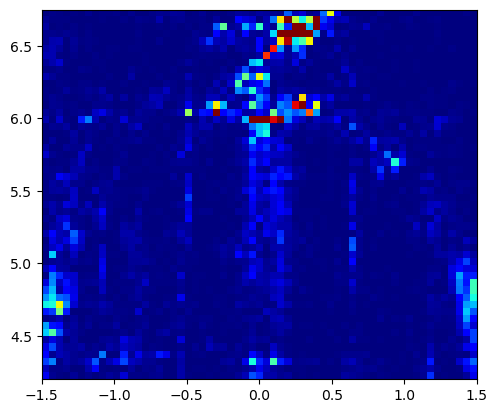

In [34]:
to_plot = MF_output
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
to_plot = to_plot[:,:]**2
plt.imshow(abs((to_plot).T), extent=[num_x_cells[0], num_x_cells[-1], num_y_cells[0], num_y_cells[-1]],cmap = 'jet',  vmin=0, vmax=0.3) # this is giving the y axis in meters, and x axis in angles 

Now you should've seen two examples of doing 1D beamforming and matched filter. In these cases, we are assuming the antenna array is one dimensional, so the antennas only have differing x-positions and the same z-positions. In the next notebook, we will be evaluating your code. In that case you will extend the 1D beamforming and matched filter to 2D. This means in these examples we will use the fully scanned locations, and this will mean you need to take into account the z-positions as well!